# Control input: heating & cooling and free-running

Objectives:
* Change the control input during the integration. 
* Swing between modles during the integration. 

ACH = 1 vol/h; Kp = 0.001 (controller gain) ⇒
Maximum time step: 479.08 s
ACH = 6 vol/h; Kp = 0.001 (controller gain) ⇒
Maximum time step: 388.03 s


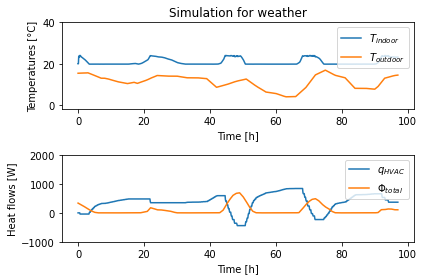

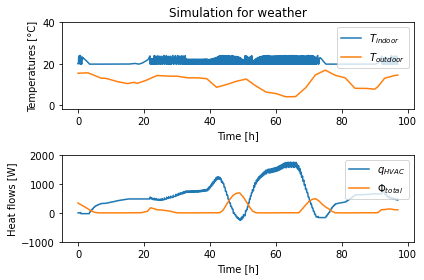

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem
import tuto

## Create the model for free-running

Let's consider that the P-controller is not effective, i.e. $K_p \rightarrow 0$. We create a model of the building in free running (the indoor temperature is free-floating).

In [2]:
K0 = 1e-3   # no controller K0 -> 0
TCa = tuto.thermal_circuit(K0)
[As, Bs, Cs, Ds] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['b'], TCa['C'], TCa['f'], TCa['y'])
dtmax = min(-2. / np.linalg.eig(As)[0])
print(f'Maximum time step in free-floating: {dtmax:.2f} s')

Maximum time step in free-floating: 388.03 s


We chose: integration time step `dt`, indoor set point `Tisp` and dead-band `DeltaT`:

In [3]:
dt = 360
Tisp = 20
DeltaT = 4

Let's simulate for this location and period:

In [4]:
filename = 'FRA_Lyon.074810_IWEC.epw'
start_date = '2000-06-03 12:00:00'
end_date = '2000-07-04 18:00:00'

Obtain the inputs

In [5]:
t, u, data = tuto.inputs(filename, start_date, end_date, dt,
                    As, Bs, Cs, Ds, K0, Tisp)

Initialize temperature vector

In [6]:
temp_exp = np.full([As.shape[0], u.shape[0]], np.inf)
temp_exp[:, 0] = Tisp * np.ones(As.shape[0])

The identity matrix:

In [7]:
I = np.eye(As.shape[0])

## Simulation in free-running
Integration in time:

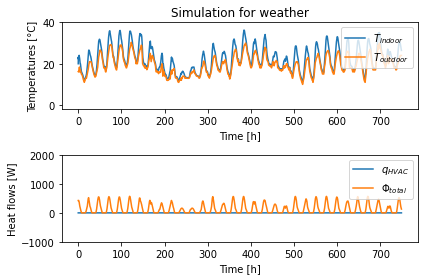

In [8]:
for k in range(u.shape[0] - 1):
    temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]
# Indoor temperature
y = Cs @ temp_exp + Ds @ u.to_numpy().T
# HVAC heat flow
q_HVAC = K0 * (data['Ti'] - y[0, :])

tuto.plot_results(t, y.T, temp_exp, q_HVAC, data)

## Feed-back control

The input in the indoor temperature node `u.iloc[k, 6]`is variable. It is changed during the integration (P-controller) as function of the difference between the set-point and the temperature at te previous time-step:

`u.iloc[k, 6] = Kp * (Tisp - y[k - 1])`

Controller gain

In [9]:
Kp = 100   # perfect controller Kpc -> infinity

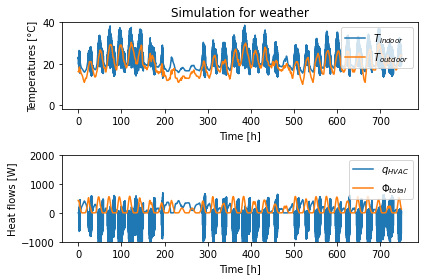

In [10]:
y = np.zeros(u.shape[0])
y[-1] = Tisp

for k in range(u.shape[0] - 1):
    # print(k, y[k - 1], temp_exp[2, k])
    if Tisp < y[k - 1] < DeltaT + Tisp:
        u.iloc[k, 6] = 0
    else:
        u.iloc[k, 6] = Kp * (Tisp - y[k - 1])

    temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]
    y[k] = Cs @ temp_exp[:, k] + Ds @ u.iloc[k]

q_HVAC = u.iloc[:, 6].to_numpy()

tuto.plot_results(t, y, temp_exp, q_HVAC, data)

## Predictive control
The input `u.iloc[k, 6]` is calculated so that the temperature at the next time-step is in the limits (one step-ahead predictive controller). The calculation is done in the `while`loop with the controller incremental gain:

In [11]:
Ki = 10

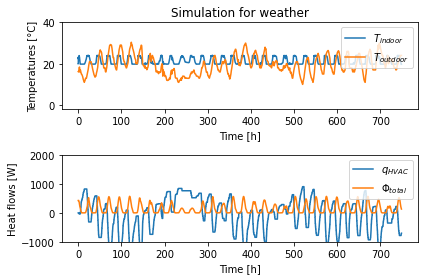

In [12]:
y = np.zeros(u.shape[0])
y[0] = Tisp

for k in range(u.shape[0] - 1):
    while (y[k] < Tisp or y[k] > DeltaT + Tisp) and abs(Tisp - y[k]) > 0.2:
        u.iloc[k, 6] += Ki * (Tisp - y[k])
        temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
            + dt * Bs @ u.iloc[k, :]
        y[k] = Cs @ temp_exp[:, k + 1] + Ds @ u.iloc[k]

    temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]
    y[k + 1] = Cs @ temp_exp[:, k] + Ds @ u.iloc[k]
    u.iloc[k + 1, 6] = u.iloc[k, 6]

q_HVAC = u.iloc[:, 6].to_numpy()
tuto.plot_results(t, y, temp_exp, q_HVAC, data)